In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

## Simple Usage

If you only need the linear power spectrum, only the basic class `CBaseEmulator` is needed.

In [2]:
import sys
sys.path.append('../')
from CEmulator.Emulator import CBaseEmulator

##### import the emulator for the original cosmology [only one single massive neutrino]
csstemu = CBaseEmulator(verbose=True, neutrino_mass_split='single')
klists  = np.logspace(-4.5, 2, 500)
zlists  = np.array([0.0, 1.0, 2.0, 3.0])

Loading the PkcbLin emulator...
Using 513 training samples.
Loading the PknnLin emulator...
Using 512 training samples [remove c0001 (no massive neutrino)].
The neutrino mass is treated as a single massive component.


In [3]:
%%time
csstemu.set_cosmos(As=2.1e-9, mnu=0.0)
pklin0 = csstemu.get_pklin(z=zlists, k=klists, Pcb=False)
csstemu.set_cosmos(As=2.1e-9, mnu=0.3)
pklin1 = csstemu.get_pklin(z=zlists, k=klists, Pcb=False)

CPU times: user 10 ms, sys: 225 µs, total: 10.2 ms
Wall time: 9.5 ms


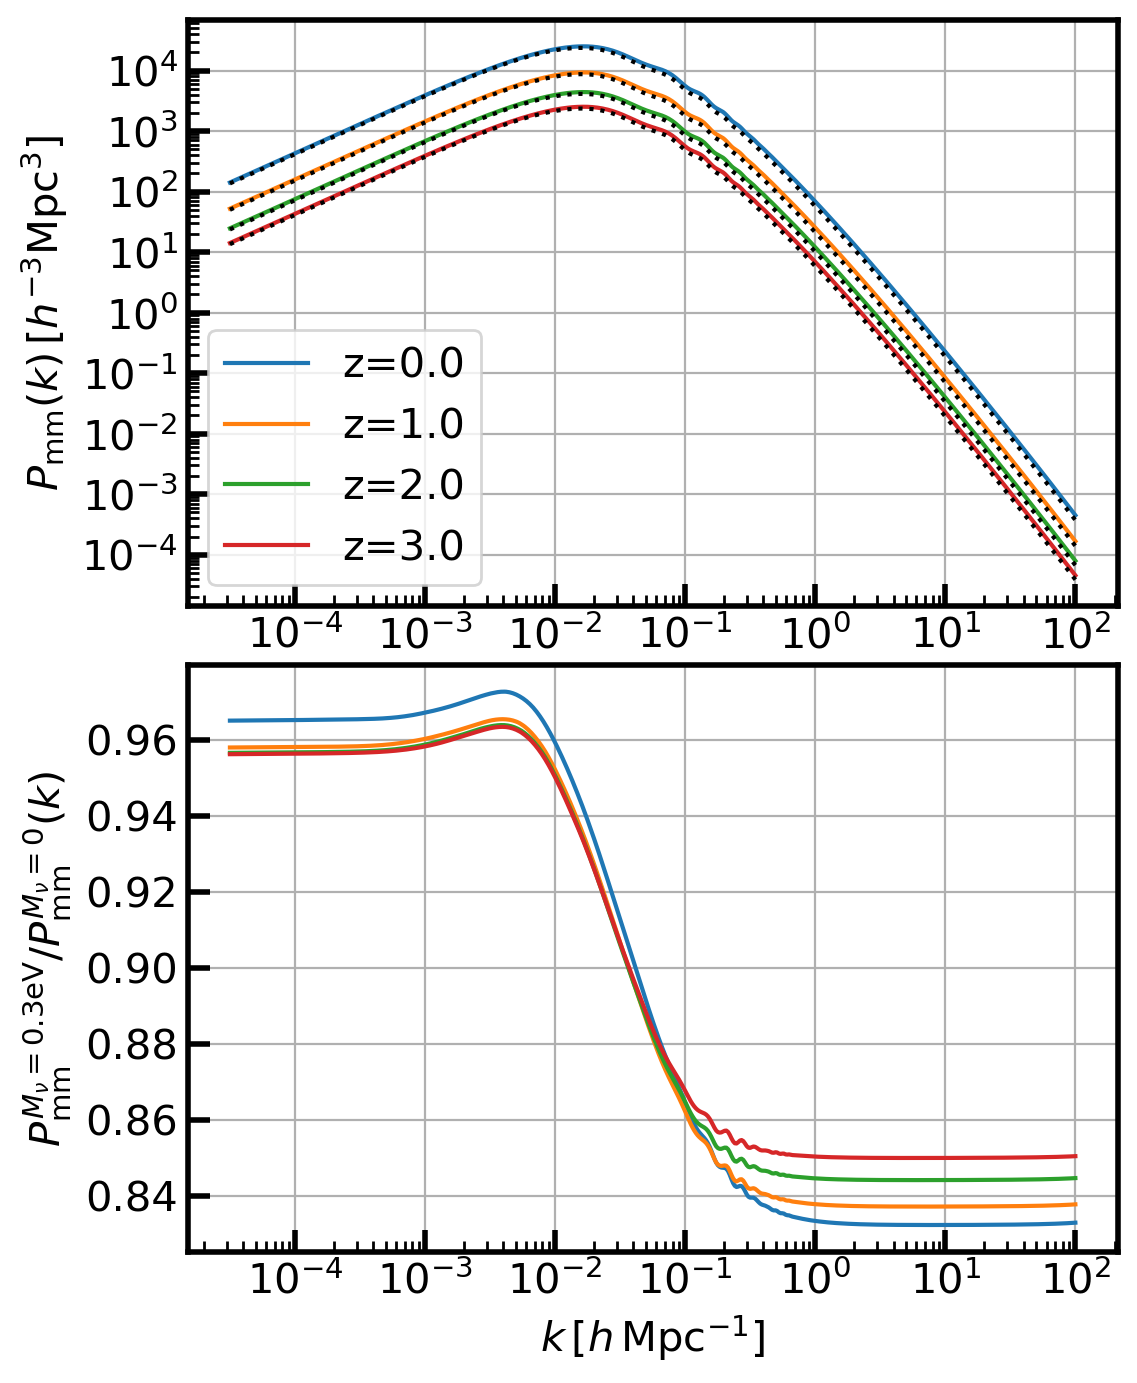

In [4]:
with plt.style.context('article'):
    gridplt = plt.GridSpec(2, 1, hspace=0.1)
    plt.figure(figsize=(6, 8))
    plt.subplot(gridplt[0])
    for ii in range(len(zlists)):
        plt.plot(klists, pklin0[ii], label='z={}'.format(zlists[ii]))
        plt.plot(klists, pklin1[ii], 'k:')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$P_{\rm mm}(k)\,[h^{-3}{\rm Mpc}^3]$')
    plt.subplot(gridplt[1])
    for ii in range(len(zlists)):
        plt.plot(klists, pklin1[ii]/pklin0[ii], label='z={}'.format(zlists[ii]))
    plt.ylabel(r'$P^{M_\nu=0.3 \mathrm{eV}}_{\rm mm}/P^{M_\nu=0}_{\rm mm}(k)$')
    plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
    plt.xscale('log')

## Compare with CLASS and CAMB

In [5]:
%%time
csstemu.set_cosmos(As=2.1e-9, mnu=0.0)
pkmmce = csstemu.get_pklin(z=zlists, k=klists, Pcb=False)

CPU times: user 4.48 ms, sys: 1.93 ms, total: 6.42 ms
Wall time: 5.7 ms


In [6]:
%%time
cosmo_class = csstemu.get_cosmo_class(z=zlists, kmax=100.0, non_linear='HMCODE')
pkmmcl = np.zeros((len(zlists), len(klists)))
h0 = csstemu.Cosmo.h0
for iz in range(len(zlists)):
    pkmmcl[iz] = np.array([cosmo_class.pk_lin(z=zlists[iz], k=ik*h0)*h0*h0*h0 for ik in klists])


CPU times: user 8.08 s, sys: 36.5 ms, total: 8.12 s
Wall time: 8.13 s


In [7]:
%%time
camb_results = csstemu.get_camb_results(z=zlists, kmax=100.0, non_linear='mead2020')
pkmmca = camb_results.get_matter_power_interpolator(nonlinear=False, 
                                                    var1='delta_tot', var2='delta_tot',
                                                    hubble_units=True, k_hunit=True).P(z=zlists, kh=klists)     

CPU times: user 6.3 s, sys: 26.7 ms, total: 6.33 s
Wall time: 6.34 s


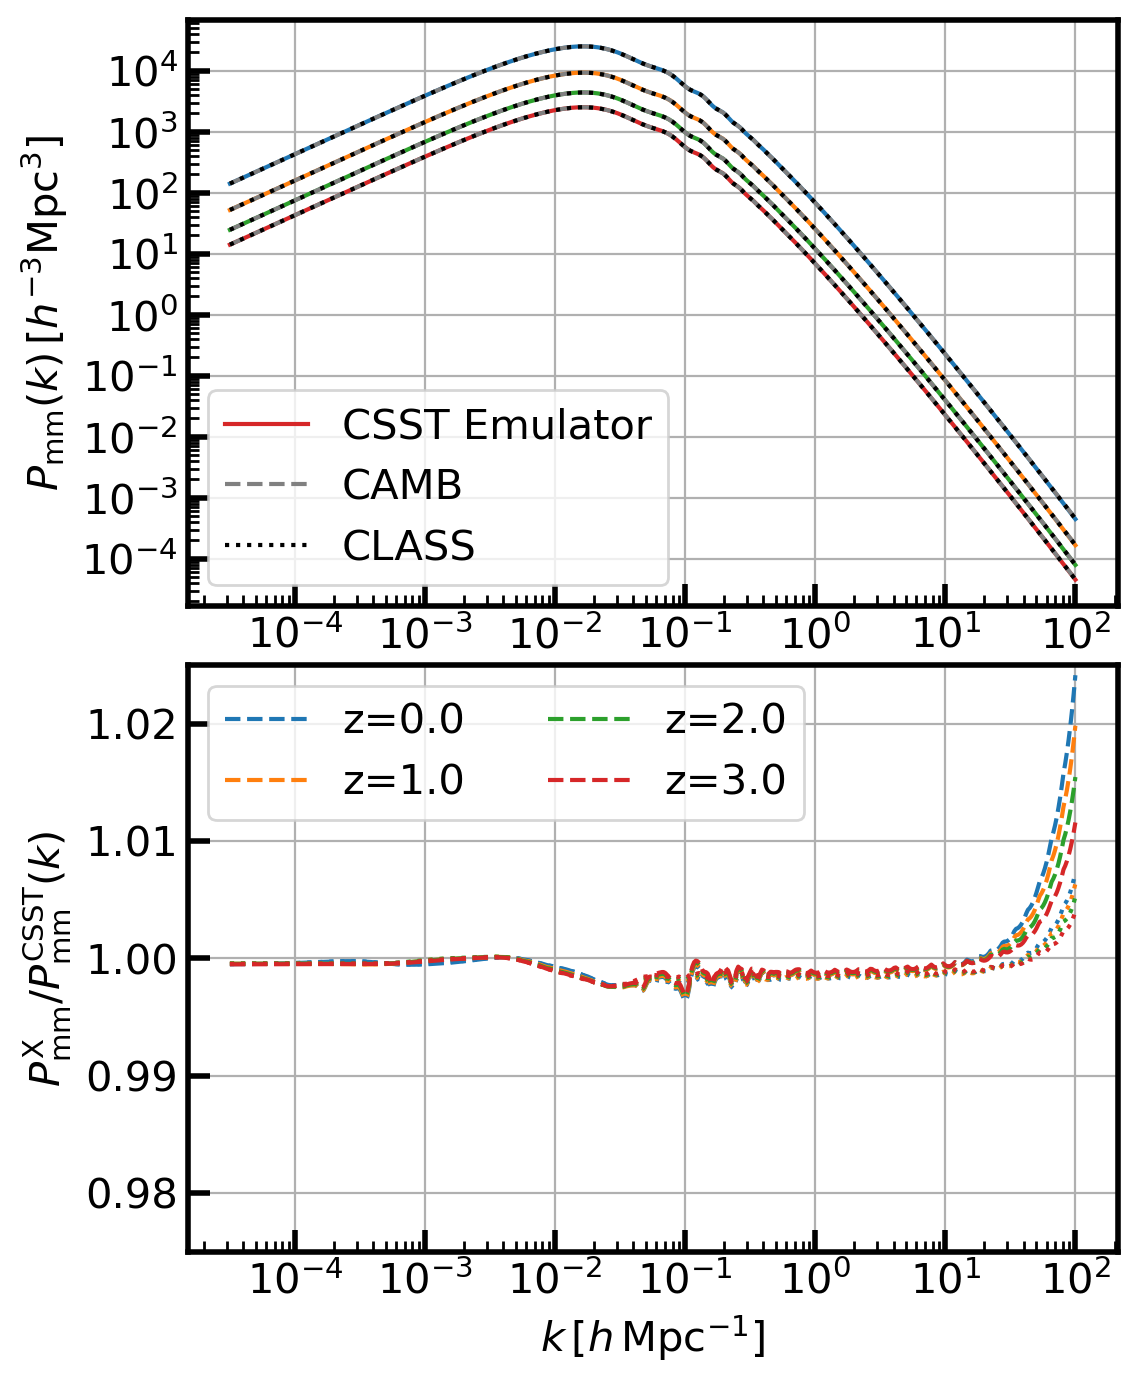

In [14]:
colors = ['C0', 'C1', 'C2', 'C3']
with plt.style.context('article'):
    gridplt = plt.GridSpec(2, 1, hspace=0.1)
    plt.figure(figsize=(6, 8))
    plt.subplot(gridplt[0])
    for ii in range(len(zlists)):
        l0, = plt.plot(klists, pkmmce[ii], color=colors[ii])
        l1, = plt.plot(klists, pkmmca[ii], color='gray', ls='--')
        l2, = plt.plot(klists, pkmmcl[ii], color='k', ls=':')
    leg2 = plt.legend([l0, l1, l2], ['CSST Emulator', 'CAMB', 'CLASS'], loc='lower left')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$P_{\rm mm}(k)\,[h^{-3}{\rm Mpc}^3]$')
    plt.subplot(gridplt[1])
    for ii in range(len(zlists)):
        plt.plot(klists, pkmmca[ii]/pkmmce[ii], '--', color=colors[ii], label='z={}'.format(zlists[ii]))
        plt.plot(klists, pkmmcl[ii]/pkmmce[ii], ':', color=colors[ii])
    plt.legend(ncol=2)
    plt.ylabel(r'$P^{\rm X}_{\rm mm}/P^{\rm CSST}_{\rm mm}(k)$')
    plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
    plt.xscale('log')
    plt.ylim(0.975, 1.025)